In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import bbknn
import matplotlib.pyplot as plt
import time
import os
import subprocess

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


font search path ['/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf', '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/afm', '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
generated new fontManager
scanpy==1.2.2 anndata==0.6.4 numpy==1.14.3 scipy==1.1.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


For whatever reason, the SCANPY figure settings don't set correctly on OpenStack nodes when called with the bulk of the code import.

In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

A dedicated computational experiment to comprehensively evaluate BBKNN's speed against other methods. Let's use the simulation setup as what was used in the initial BBKNN testing, except with 2000 genes. 2000 seems like a nice representative number for potential HVG counts, being pretty close to what we got in the pancreatic data. Generate two cell profiles and four batch signatures.

This is set up to run in a folder called `experiment`, in the same directory as your `scanorama` folder, needs the directory `scanorama/data/simul` to exist, and requires the following files present:

## `scanorama/conf/simul.txt`
    data/simul/0
    data/simul/1
    data/simul/2
    data/simul/3

## `scanorama/bin/simul.py`
    import numpy as np
    from sklearn.preprocessing import normalize, LabelEncoder
    import sys

    from process import load_names, merge_datasets, save_datasets
    from scanorama import correct, visualize, process_data
    from scanorama import dimensionality_reduce

    import time

    data_names = [
        'data/simul/0',
        'data/simul/1',
        'data/simul/2',
        'data/simul/3'
    ]

    if __name__ == '__main__':
        datasets, genes_list, n_cells = load_names(data_names)
        t1 = time.time()
        datasets, genes = correct(datasets, genes_list)
        datasets = [ normalize(ds, axis=1) for ds in datasets ]
        t2 = time.time()
        print(t2-t1)

## `experiment/mnnCount.R`
    library(scran)

    df0 = read.table('../scanorama/data/simul/0.txt')
    df1 = read.table('../scanorama/data/simul/1.txt')
    df2 = read.table('../scanorama/data/simul/2.txt')
    df3 = read.table('../scanorama/data/simul/3.txt')

    t1 = Sys.time()
    mnncount = mnnCorrect(data.matrix(df0), data.matrix(df1), data.matrix(df2), data.matrix(df3),
                          BPPARAM=MulticoreParam(detectCores()))
    t2 = Sys.time()

    write(as.numeric(difftime(t2,t1,units='secs')), stdout())

## `experiment/CCA.R`
    library(Seurat)

    df0 = read.table('../scanorama/data/simul/0.txt')
    df1 = read.table('../scanorama/data/simul/1.txt')
    df2 = read.table('../scanorama/data/simul/2.txt')
    df3 = read.table('../scanorama/data/simul/3.txt')

    df0 = data.matrix(df0)
    df1 = data.matrix(df1)
    df2 = data.matrix(df2)
    df3 = data.matrix(df3)

    #CCA is not particularly appreciative of having negative values in the data for some reason
    #as this is a simulation with no ramifications of the results, just zero them
    df0[df0<0] = 0
    df1[df1<0] = 0
    df2[df2<0] = 0
    df3[df3<0] = 0

    colnames(df0) = 1:dim(df0)[2]
    colnames(df1) = (dim(df0)[2]+1):(2*dim(df0)[2])
    colnames(df2) = (2*dim(df0)[2]+1):(3*dim(df0)[2])
    colnames(df3) = (3*dim(df0)[2]+1):(4*dim(df0)[2])

    sdf0 = CreateSeuratObject(df0)
    sdf0@meta.data$batch = '0'
    sdf0 = ScaleData(sdf0)
    sdf0@var.genes = rownames(df0)

    sdf1 = CreateSeuratObject(df1)
    sdf1@meta.data$batch = '1'
    sdf1 = ScaleData(sdf1)
    sdf1@var.genes = rownames(df1)

    sdf2 = CreateSeuratObject(df2)
    sdf2@meta.data$batch = '2'
    sdf2 = ScaleData(sdf2)
    sdf2@var.genes = rownames(df2)

    sdf3 = CreateSeuratObject(df3)
    sdf3@meta.data$batch = '3'
    sdf3 = ScaleData(sdf3)
    sdf3@var.genes = rownames(df3)

    t1 = Sys.time()
    srat = RunMultiCCA(list(sdf0, sdf1, sdf2, sdf3), genes.use=rownames(df0), num.ccs=20)
    srat = AlignSubspace(srat, reduction.type='cca', grouping.var='batch', dims.align=1:20)
    t2 = Sys.time()

    write(as.numeric(difftime(t2,t1,units='secs')), stdout())

In [3]:
celltypeA = np.random.random((1,2000))**10
celltypeB = np.random.random((1,2000))**10

batch0 = np.random.normal(size=(1,2000),loc=1,scale=0.5)
batch1 = np.random.normal(size=(1,2000),loc=1,scale=0.5)
batch2 = np.random.normal(size=(1,2000),loc=1,scale=0.5)
batch3 = np.random.normal(size=(1,2000),loc=1,scale=0.5)

Create four equal sized batches, each made up of equal proportions of the two cell types. Scale the total cell count in the setup by 1,000 until 15,000. Repeat each cell count five times to get some measure of run time variance. Run BBKNN, mnnpy, Scanorama, mnnCorrect, CCA. The last two are in R, and make use of the data export created for Scanorama to get the data into R. Only time the actual batch correction part, excluding all the data formatting for e.g. Scanorama and CCA.

It should be noted that Scanorama wants to be ran on the complete gene space, so just feeding it 2,000 genes simulating an HVG pool is going to make run times faster than would be normally encountered when processing the entire gene space. In spite of that, BBKNN is faster.

The actual output captured below is partial as this was configured on an OpenStack node via an SSH-forwarded Jupyter Notebook, and the way forwarding works is that the notebook has to be physically open to catch the actual output.

In [ ]:
bbknn_mean = []
bbknn_std = []
mnnpy_mean = []
mnnpy_std = []
scanorama_mean = []
scanorama_std = []
mnncorrect_mean = []
mnncorrect_std = []
cca_mean = []
cca_std = []
for N in np.arange(1,16):
    bbknn_time = []
    mnnpy_time = []
    scanorama_time = []
    mnncorrect_time = []
    cca_time = []
    for rep in np.arange(5):
        #data prep
        expr_template = np.vstack((np.tile(celltypeA,(125*N,1)),np.tile(celltypeB,(125*N,1))))
        exprs0 = (expr_template + np.random.normal(size=(250*N,2000),scale=0.1)) * batch0
        exprs1 = (expr_template + np.random.normal(size=(250*N,2000),scale=0.1)) * batch1
        exprs2 = (expr_template + np.random.normal(size=(250*N,2000),scale=0.1)) * batch2
        exprs3 = (expr_template + np.random.normal(size=(250*N,2000),scale=0.1)) * batch3
        adata = anndata.AnnData(X=np.vstack((exprs0,exprs1,exprs2,exprs3)))
        adata.obs['celltype'] = np.tile(np.concatenate((np.repeat('A',125*N),np.repeat('B',125*N))),4)
        adata.obs['batch'] = [str(i) for i in np.repeat(np.arange(4),250*N)]
        sc.tl.pca(adata)

        #BBKNN
        t1 = time.time()
        bbknn.bbknn(adata, n_pcs=20)
        t2 = time.time()
        bbknn_time.append(t2-t1)

        #mnnpy
        t1 = time.time()
        corrected = sc.pp.mnn_correct(adata[adata.obs['batch']=='0'],adata[adata.obs['batch']=='1'],
                                     adata[adata.obs['batch']=='2'],adata[adata.obs['batch']=='3'])
        t2 = time.time()
        mnnpy_time.append(t2-t1)

        #scanorama
        for batch in np.arange(4):
            df = pd.DataFrame(data=adata[adata.obs['batch']==str(batch)].X.transpose(),
                              index=adata[adata.obs['batch']==str(batch)].var_names,
                              columns=np.arange(np.sum(adata.obs['batch']==str(batch))))
            df.to_csv('../scanorama/data/simul/'+str(batch)+'.txt',sep='\t')
        os.chdir('../scanorama/')
        subprocess.run('python3 bin/process.py conf/simul.txt', shell=True)
        res = subprocess.run('python3 bin/simul.py', shell=True, stdout=subprocess.PIPE)
        scanorama_time.append(float(res.stdout.decode('utf-8').split('\n')[-2]))
        os.chdir('../experiment/')
        
        #mnnCorrect
        res = subprocess.run('Rscript mnnCount.R', shell=True, stdout=subprocess.PIPE)
        mnncorrect_time.append(float(res.stdout.decode('utf-8').split('\n')[-2]))
        
        #CCA
        res = subprocess.run('Rscript CCA.R', shell=True, stdout=subprocess.PIPE)
        cca_time.append(float(res.stdout.decode('utf-8').split('\n')[-2]))
    bbknn_mean.append(np.mean(bbknn_time))
    bbknn_std.append(np.std(bbknn_time))
    mnnpy_mean.append(np.mean(mnnpy_time))
    mnnpy_std.append(np.std(mnnpy_time))
    scanorama_mean.append(np.mean(scanorama_time))
    scanorama_std.append(np.std(scanorama_time))
    mnncorrect_mean.append(np.mean(mnncorrect_time))
    mnncorrect_std.append(np.std(mnncorrect_time))
    cca_mean.append(np.mean(cca_time))
    cca_std.append(np.std(cca_time))

computing batch balanced neighbors
    finished (0:00:00.18) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 3: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 3: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 3: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


Now that the complete harvesting is complete, we can collate the means and standard deviations into a single exportable file. This takes a while to run, so may as well keep what we got here.

In [5]:
res=pd.DataFrame(data=np.vstack((bbknn_mean,bbknn_std,mnnpy_mean,mnnpy_std,scanorama_mean,scanorama_std,
                                 mnncorrect_mean,mnncorrect_std,cca_mean,cca_std)),
                 index=['BBKNN_mean','BBKNN_std','mnnpy_mean','mnnpy_std','Scanorama_mean','Scanorama_std',
                        'mnnCorrect_mean','mnnCorrect_std','CCA_mean','CCA_std'],
                 columns=np.arange(1,16)*1000)
print(res)
res.to_csv('all_methods_2000genes.csv')

                      1000        2000        3000        4000        5000   \
BBKNN_mean         0.189073    0.367352    0.550357    0.744445    1.046839   
BBKNN_std          0.012230    0.014332    0.024347    0.035990    0.062975   
mnnpy_mean         3.658017   11.158853   23.632973   43.300657   64.855064   
mnnpy_std          0.041805    0.122393    0.605129    1.604927    1.458360   
Scanorama_mean     1.950538    3.995492    6.360131    8.444333   10.337699   
Scanorama_std      0.114877    0.067957    0.752138    0.861995    0.220531   
mnnCorrect_mean   11.250144   39.456468   61.327324  106.083200  161.514120   
mnnCorrect_std     0.138196    1.353765    0.376472    0.924305    0.863529   
CCA_mean         331.471840  409.441120  477.036500  577.443620  616.284800   
CCA_std           13.532929   15.719275   12.484611   29.687248   21.703452   

                      6000        7000        8000         9000         10000  \
BBKNN_mean         1.298329    1.486023    1.7463

Visualising the results, with a log-scale run time axis.

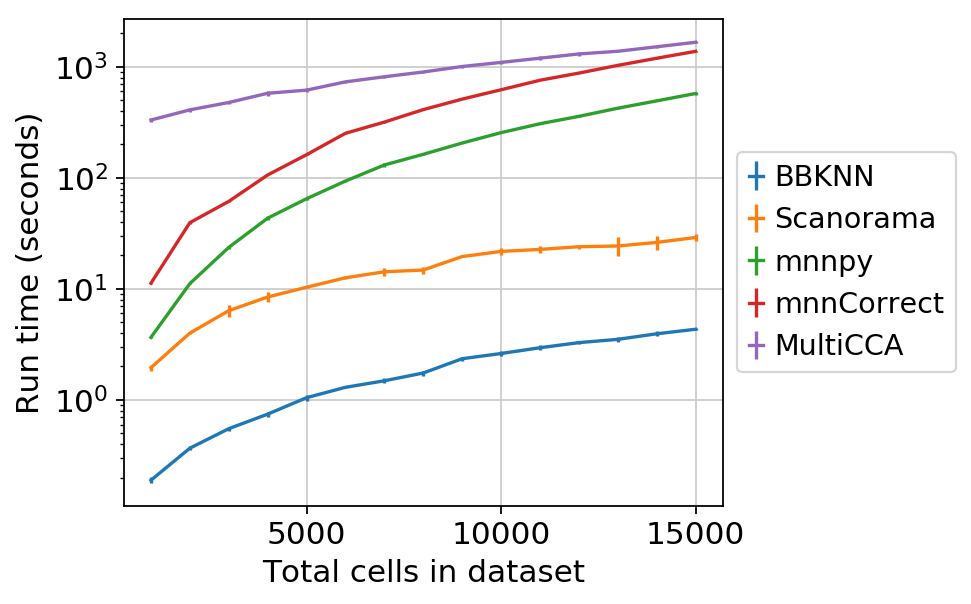

In [6]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)

plt.errorbar(np.arange(1,16)*1000,bbknn_mean,bbknn_std)
plt.errorbar(np.arange(1,16)*1000,scanorama_mean,scanorama_std)
plt.errorbar(np.arange(1,16)*1000,mnnpy_mean,mnnpy_std)
plt.errorbar(np.arange(1,16)*1000,mnncorrect_mean,mnncorrect_std)
plt.errorbar(np.arange(1,16)*1000,cca_mean,cca_std)
plt.yscale('log')
plt.xlabel('Total cells in dataset')
plt.ylabel('Run time (seconds)')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(['BBKNN','Scanorama','mnnpy','mnnCorrect','MultiCCA'], loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('all_methods_2000genes.pdf',bbox_inches='tight')

plt.show()